# Georgian Text Recognizer

This application takes an image (jpg) file containing Georgian text and turns the text into typed text.

* For a Machine Learning Algorthm to guess a letter, it should be Normilized. All of the letters should be Standardized.

* Before Standardization letters should be separated from one another.

* The letters should be separated from a single line of the read Image.

* There should be a function that reads individual lines from full text Image.

## Data Preparation

In [ ]:
from PIL import Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

np.random.seed(12)

### Function for Previewing a Letter

In [ ]:
# Image Size of a single letter
IMG_SIZE = 30

In [ ]:
def show_image(image):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image);

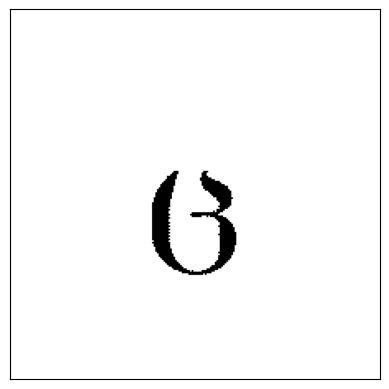

In [ ]:
single_letter = Image.open("drive/MyDrive/DS/image-to-text/staging/letter.png").convert("1")
show_image(single_letter)

### Function for Standardizing Letters

* Each letter should be in the middle of the Image.
* Each image's side length should be `IMG_SIZE`.
* Each image should be in back and white.

In [ ]:
def standardize_letter(image):
    img_w, img_h = image.size
    letter_x = []
    letter_y = []

    # Locate and add the black pixels to appropriate lists
    for x in range(img_w):
        for y in range(img_h):
            if image.getpixel((x, y)) < 125.5:
                letter_x.append(x)
                letter_y.append(y)

    # Change the coordinates to be the bouding box of the black pixels
    letter_y_moved = [y-min(letter_y) for y in letter_y]
    letter_x_moved = [x-min(letter_x) for x in letter_x]
    black_pixels = zip(letter_x_moved, letter_y_moved)

    # Create Image and color the pixels
    letter_new = Image.new(mode="1", size=(max(letter_x_moved)+1, max(letter_y_moved)+1))
    letter_new_pixels = letter_new.load()

    for x, y  in black_pixels:
        letter_new_pixels[x, y] = 1

    # Resize Image to the Standard IMG_SIZE
    letter_new = letter_new.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)

    return letter_new

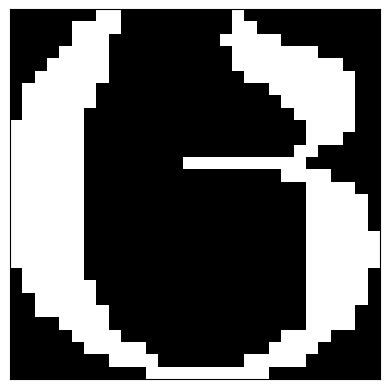

In [ ]:
standard_letter = standardize_letter(single_letter)
show_image(standard_letter)

### Function for Separating Letters from a Single Line

* The blank space should be ignored before the first letter in each line.
* The blank space should be ignored after the last letter in each line.
* The spaces between words should be accounted for.

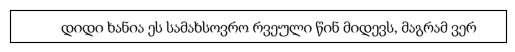

In [ ]:
single_line = Image.open("drive/MyDrive/DS/image-to-text/staging/single-line.jpg").convert("1")
show_image(single_line)

In [ ]:
def get_letters(image):
    line_w, line_h = image.size
    letter_start_col = line_w
    letter_end_col = 0
    letters = []
    index = 0
    spaces = []
    counter = 0
    letter_end = False
    first_letter = False

    # Go over pixels
    for x in range(line_w):
        for y in range(line_h):

            # Found a black pixel
            if image.getpixel((x, y)) < 125.5:

                # Ignored the starting black space
                first_letter = True

                # If the found black pixel is not part of the previous letter
                # a space should be appended to the list with the count of horizontal
                # white pixels to determine if its is a space between two letters
                # or two words
                if letter_end:
                    index += 1
                    spaces.append((index, counter))
                    letters.append(Image.new(mode="1", size=(8, 8)))
                    counter = 0

                letter_end = False

                # Assign horizontal bounds of a letter to variables
                if letter_start_col > x:
                    letter_start_col = x
                else:
                    letter_end_col = x

                break

            # If the whole column consists of white pixels and
            # the horizontal bounds have been assigned correctly
            # it means that the whole letter has been found and should be
            # appended to the letters list
            # Spaces list should be updated too that the letter has been found
            elif (y == line_h-1) and (letter_end_col > letter_start_col):
                letter = standardize_letter(image.crop((letter_start_col, 0, letter_end_col+1, line_h)))
                letters.append(letter)
                index += 1
                spaces.append((index, 0))
                letter_start_col = line_w
                letter_end_col = 0

            # If the whole column consists of white pixels and the horizontal
            # bounds haven't been assigned correctly it means that it is either
            # white space between letters or words
            elif first_letter and (y == line_h-1):
                letter_end = True
                counter += 1

    # Remove spaces between letters from the list so it leaves just letters and
    # spaces between words
    to_remove = [i[0]-1 for i in spaces if i[1] < 10 and i[1] != 0]
    letters = [i for j, i in enumerate(letters) if j not in to_remove]

    return letters

In [ ]:
line_letters = get_letters(single_line)

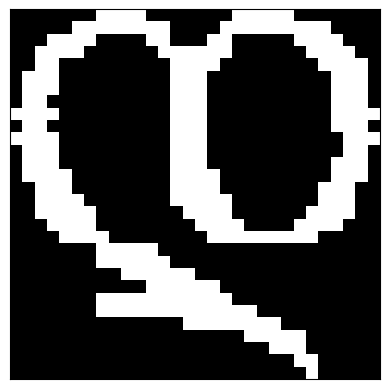

In [ ]:
show_image(line_letters[0])

### Function for Separating Lines from the Whole Text

* Vertical white spaces should be ignored.

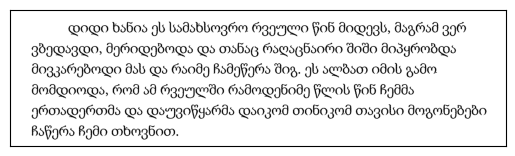

In [ ]:
multi_line = Image.open("drive/MyDrive/DS/image-to-text/staging/multiline-text.jpg").convert("1")
show_image(multi_line)

In [ ]:
def get_lines(image):
    text_w, text_h = image.size
    line_start_row = text_h
    line_end_row = 0
    lines = []

    # Go over pixels
    for y in range(text_h):
        for x in range(text_w):

            # Found black pixel in a row
            if image.getpixel((x, y)) < 125.5:

                # Assign the vertical bounds of the letters in a line
                if line_start_row > y:
                    line_start_row = y
                else:
                    line_end_row = y

                break

            # If the whole row consists of white pixels and
            # the vertical bounds have been assigned correctly
            # it means that the whole line has been found and should be
            # appended to the lines list
            elif (x == text_w-1) and (line_end_row > line_start_row):
                lines.append(image.crop((0, line_start_row, text_w, line_end_row+1)))
                line_start_row = text_h
                line_end_row = 0

    return lines

In [ ]:
lines = get_lines(multi_line)

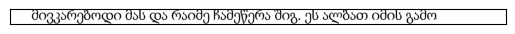

In [ ]:
show_image(lines[2])

### Function for Turning Image Text to Separate Standardized Letter Images

In [ ]:
def multiline_to_letters(image):
    all_letters = []
    lines = get_lines(image)

    for i in range(len(lines)):
        line_letters = get_letters(lines[i])
        all_letters.append(line_letters)
        space = [Image.new(mode="1", size=(8, 8))]
        all_letters.append(space)

    return [item for sublist in all_letters for item in sublist]

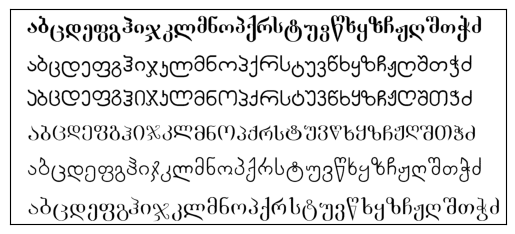

In [ ]:
multiline_text = Image.open("drive/MyDrive/DS/image-to-text/staging/fonts.jpg").convert("1")
show_image(multiline_text)

In [ ]:
multiline_letters = multiline_to_letters(multiline_text)

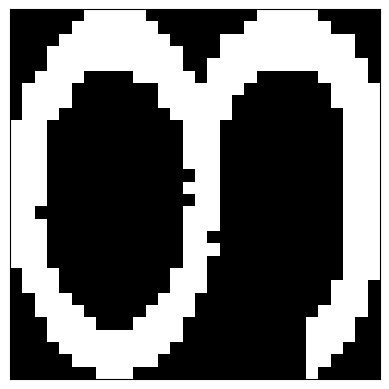

In [ ]:
show_image(multiline_letters[64])

## Choosing Machine Learning Models

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

### Prepating Training Data

In [ ]:
# True labels of the data
labels_df = pd.read_csv("drive/MyDrive/DS/image-to-text/labels.csv")

In [ ]:
labels_df.head()

,id,labels
0,letter-0.png,ა
1,letter-1.png,ბ
2,letter-2.png,ც
3,letter-3.png,დ
4,letter-4.png,ე


In [ ]:
# Data filenames to read the images
filepaths = ["drive/MyDrive/DS/image-to-text/fonts/" + fname for fname in labels_df["id"]]

In [ ]:
labels = np.array(labels_df["labels"])

In [ ]:
labels

array(['ა', 'ბ', 'ც', 'დ', 'ე', 'ფ', 'გ', 'ჰ', 'ი', 'ჯ', 'კ', 'ლ', 'მ',
       'ნ', 'ო', 'პ', 'ქ', 'რ', 'ს', 'ტ', 'უ', 'ვ', 'წ', 'ხ', 'ყ', 'ზ',
       'ჩ', 'ჟ', 'ღ', 'შ', 'თ', 'ჭ', 'ძ', 'ა', 'ბ', 'ც', 'დ', 'ე', 'ფ',
       'გ', 'ჰ', 'ი', 'ჯ', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ', 'ქ', 'რ', 'ს',
       'ტ', 'უ', 'ვ', 'წ', 'ხ', 'ყ', 'ზ', 'ჩ', 'ჟ', 'ღ', 'შ', 'თ', 'ჭ',
       'ძ', 'ა', 'ბ', 'ც', 'დ', 'ე', 'ფ', 'გ', 'ჰ', 'ი', 'ჯ', 'კ', 'ლ',
       'მ', 'ნ', 'ო', 'პ', 'ქ', 'რ', 'ს', 'ტ', 'უ', 'ვ', 'წ', 'ხ', 'ყ',
       'ზ', 'ჩ', 'ჟ', 'ღ', 'შ', 'თ', 'ჭ', 'ძ', 'ა', 'ბ', 'ც', 'დ', 'ე',
       'ფ', 'გ', 'ჰ', 'ი', 'ჯ', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ', 'ქ', 'რ',
       'ს', 'ტ', 'უ', 'ვ', 'წ', 'ხ', 'ყ', 'ზ', 'ჩ', 'ჟ', 'ღ', 'შ', 'თ',
       'ჭ', 'ძ', 'ა', 'ბ', 'ც', 'დ', 'ე', 'ფ', 'გ', 'ჰ', 'ი', 'ჯ', 'კ',
       'ლ', 'მ', 'ნ', 'ო', 'პ', 'ქ', 'რ', 'ს', 'ტ', 'უ', 'ვ', 'წ', 'ხ',
       'ყ', 'ზ', 'ჩ', 'ჟ', 'ღ', 'შ', 'თ', 'ჭ', 'ძ', 'ა', 'ბ', 'ც', 'დ',
       'ე', 'ფ', 'გ', 'ჰ', 'ი', 'ჯ', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ

In [ ]:
def fpaths_to_imgs(fpaths):
  images = []

  # Go over filepaths and standardize the opened images
  for i in fpaths:
    img = Image.open(i).convert("1")
    img = standardize_letter(img)
    images.append(img)

  return images

In [ ]:
def imgs_to_df(images):
  columns = ["pixel" + str(x+1) for x in range(IMG_SIZE*IMG_SIZE)]
  df = pd.DataFrame(columns=columns)

  # Convert Images into DataFrame of 0s and 1s
  for img in images:
    arr = np.asarray(img).astype(int).flatten()
    row = {column: pixel for column, pixel in zip(columns, arr)}
    temp_df = pd.DataFrame(row, index=[0])
    df = pd.concat([df, temp_df], axis=0, ignore_index=True)

  return df

In [ ]:
# Open the training images
imgs = fpaths_to_imgs(filepaths)

In [ ]:
# Convert the training images into DataFrame
df = imgs_to_df(imgs).astype(int)

In [ ]:
df.shape, labels_df.shape

((453, 900), (453, 2))

In [ ]:
# Add labels column to df
df = pd.concat([df, labels_df["labels"]], axis=1)

In [ ]:
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel892,pixel893,pixel894,pixel895,pixel896,pixel897,pixel898,pixel899,pixel900,labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ა
1,0,0,0,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,ბ
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,ც
3,0,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,დ
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ე


In [ ]:
print("Unique Labels: ", np.unique(labels))
print("\nNumber of Unique Labels: ", len(np.unique(labels)))

Unique Labels:  ['!' ',' '.' ':' ';' '?' 'ა' 'ბ' 'გ' 'დ' 'ე' 'ვ' 'ზ' 'თ' 'ი' 'კ' 'ლ' 'მ'
 'ნ' 'ო' 'პ' 'ჟ' 'რ' 'ს' 'ტ' 'უ' 'ფ' 'ქ' 'ღ' 'ყ' 'შ' 'ჩ' 'ც' 'ძ' 'წ' 'ჭ'
 'ხ' 'ჯ' 'ჰ' '“' '„']

Number of Unique Labels:  41


### Prepating Test Data

In [ ]:
test_label = "დიდი ხანია ეს სამახსოვრო რვეული წინ მიდევს, მაგრამ ვერ ვბედავდი, მერიდებოდა და თანაც რაღაცნაირი შიში მიპყრობდა მივკარებოდი მას და რაიმე ჩამწერეა შიგ. ეს ალბათ იმის გამო მომდიოდა, რომ ამ რვეულში რამოდენიმე წლის წინ ჩემმა ერთადერთმა და დაუვიწყარმა დაიკომ თინიკომ თავისი მოგონებები ჩაწერა ჩემი თხოვნით."

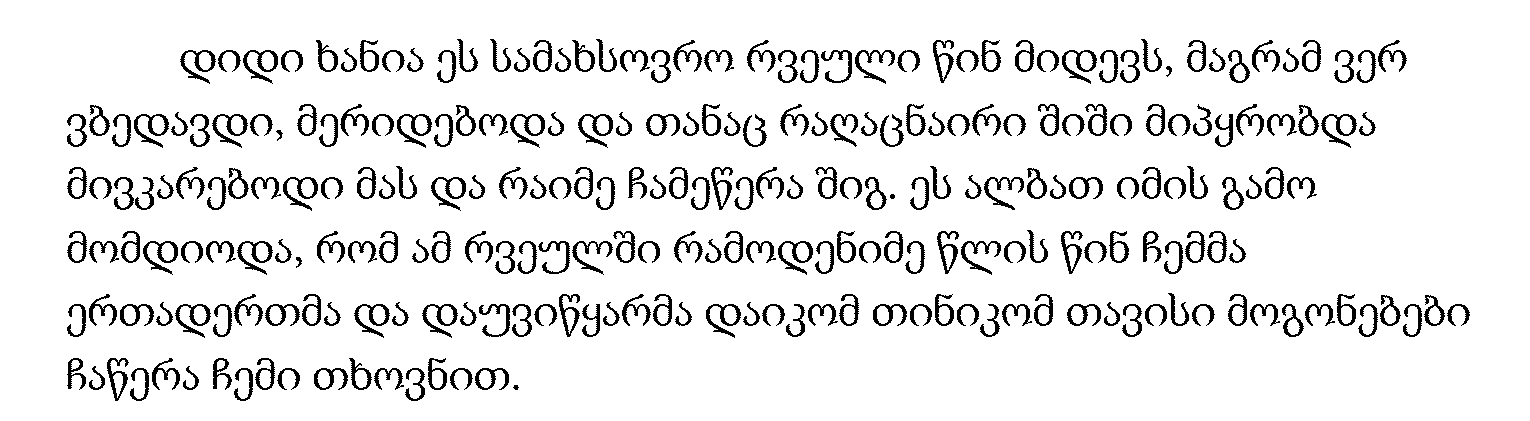

In [ ]:
test_image = Image.open("drive/MyDrive/DS/image-to-text/staging/multiline-text.jpg").convert("1")
test_image

In [ ]:
test_letters = multiline_to_letters(test_image)

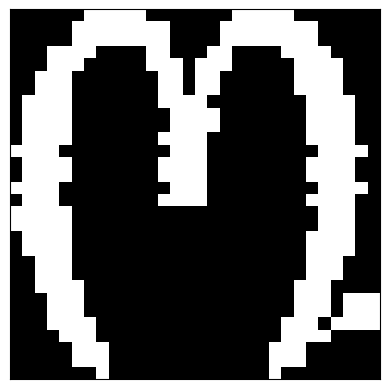

In [ ]:
show_image(test_letters[23])

In [ ]:
# Function to eliminate any unnecesary spaces between letters
def get_space_indices(letters):
  indices = []

  for index, letter in enumerate(letters):
    if letter.size == (8, 8):
      indices.append(index)

  letters = [i for j, i in enumerate(letters) if j not in indices]

  return letters, indices

In [ ]:
test_letters, space_indices = get_space_indices(test_letters)

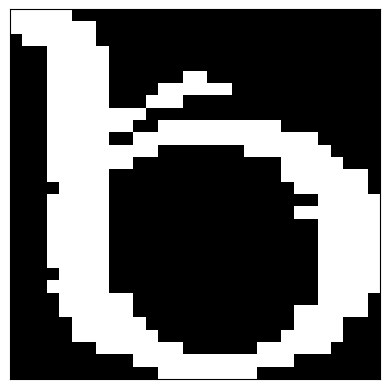

In [ ]:
show_image(test_letters[4])

In [ ]:
test_df = imgs_to_df(test_letters)

In [ ]:
test_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel891,pixel892,pixel893,pixel894,pixel895,pixel896,pixel897,pixel898,pixel899,pixel900
0,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df.shape

(254, 900)

In [ ]:
test_df.dtypes

pixel1      object
pixel2      object
pixel3      object
pixel4      object
pixel5      object
             ...  
pixel896    object
pixel897    object
pixel898    object
pixel899    object
pixel900    object
Length: 900, dtype: object

In [ ]:
test_df = test_df.astype(int)

### Predicted Labels to String Text

In [ ]:
space_indices

[4,
 10,
 13,
 24,
 31,
 35,
 43,
 50,
 54,
 64,
 75,
 78,
 84,
 95,
 99,
 109,
 121,
 125,
 128,
 134,
 143,
 148,
 151,
 157,
 162,
 167,
 177,
 181,
 184,
 191,
 202,
 207,
 211,
 217,
 228,
 231,
 243,
 250,
 258,
 265,
 276,
 283,
 288,
 297]

In [ ]:
def preds_to_string(array, spaces):
  text = ""

  for index in spaces:
    array = np.insert(array, index, " ")

  char_list = array.tolist()

  for char in char_list:
    text += char

  return text

### Keras Deep Learning Model

In [ ]:
# Reshape for deep learning model
test_df = test_df.values.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
unique_labels = np.unique(labels)
boolean_df_labels = np.array([np.array(label == unique_labels) for label in labels]).astype(np.float32)

In [ ]:
X = df.drop(["labels"], axis=1)
y = boolean_df_labels

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2)

In [ ]:
# Reshape the values so it is in the form of a square
X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.values.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
keras_model = Sequential()

keras_model.add(Conv2D(filters=32, kernel_size=(4, 4), padding='Same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
keras_model.add(BatchNormalization())

keras_model.add(Conv2D(filters=32, kernel_size=(4, 4), padding='Same', activation='relu'))
keras_model.add(BatchNormalization())

keras_model.add(MaxPool2D(pool_size=(2, 2)))
keras_model.add(Dropout(0.25))

keras_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'))
keras_model.add(BatchNormalization())

keras_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'))
keras_model.add(BatchNormalization())
keras_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
keras_model.add(Dropout(0.25))

keras_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same',  activation='relu'))
keras_model.add(BatchNormalization())
keras_model.add(Dropout(0.25))

keras_model.add(Flatten())
keras_model.add(Dense(16, activation='relu'))
keras_model.add(BatchNormalization())
keras_model.add(Dropout(0.25))

keras_model.add(Dense(41, activation ='softmax'))

In [ ]:
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 8

datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)

In [ ]:
epochs = 50

history = keras_model.fit(train_gen, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
46/46 - 9s - loss: 1.5256 - accuracy: 0.5994 - val_loss: 1.0690 - val_accuracy: 0.6484 - 9s/epoch - 187ms/step
Epoch 2/50
46/46 - 3s - loss: 1.4810 - accuracy: 0.5967 - val_loss: 0.9604 - val_accuracy: 0.7363 - 3s/epoch - 60ms/step
Epoch 3/50
46/46 - 5s - loss: 1.4191 - accuracy: 0.6188 - val_loss: 0.7933 - val_accuracy: 0.7912 - 5s/epoch - 102ms/step
Epoch 4/50
46/46 - 3s - loss: 1.3374 - accuracy: 0.6630 - val_loss: 0.7114 - val_accuracy: 0.8242 - 3s/epoch - 62ms/step
Epoch 5/50
46/46 - 3s - loss: 1.2819 - accuracy: 0.6547 - val_loss: 0.6581 - val_accuracy: 0.8352 - 3s/epoch - 61ms/step
Epoch 6/50
46/46 - 3s - loss: 1.2545 - accuracy: 0.6657 - val_loss: 0.6446 - val_accuracy: 0.8132 - 3s/epoch - 70ms/step
Epoch 7/50
46/46 - 3s - loss: 1.1317 - accuracy: 0.7182 - val_loss: 0.6235 - val_accuracy: 0.8681 - 3s/epoch - 62ms/step
Epoch 8/50
46/46 - 3s - loss: 1.1319 - accuracy: 0.7210 - val_loss: 0.5941 - val_accuracy: 0.8462 - 3s/epoch - 60ms/step
Epoch 9/50
46/46 - 5s - loss: 

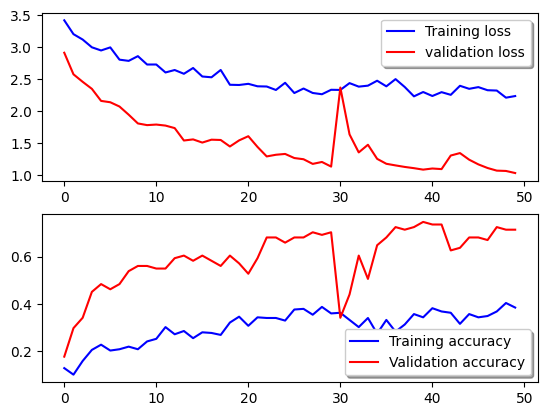

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
#pkl_filename = "drive/MyDrive/DS/image-to-text/models/keras_model.pkl"

#with open(pkl_filename, "wb") as file:
#    pickle.dump(keras_model, file)

In [ ]:
with open("drive/MyDrive/DS/image-to-text/models/keras_model.pkl", "rb") as file:
  keras_model = pickle.load(file)

In [ ]:
preds_keras = keras_model.predict(test_df)
preds_keras

8/8 [==============================] - 1s 64ms/step


array([[1.3832749e-06, 1.7724105e-08, 1.7167449e-09, ..., 4.4604715e-07,
        1.0537698e-05, 2.6201649e-06],
       [6.8188717e-07, 7.5458811e-05, 1.3049515e-05, ..., 1.0852231e-08,
        3.5106690e-04, 2.8339279e-04],
       [1.3398845e-06, 1.5438220e-08, 1.0757073e-09, ..., 3.7052294e-07,
        1.0498841e-05, 2.7456094e-06],
       ...,
       [6.5834473e-07, 7.2458613e-05, 1.2381698e-05, ..., 1.0456532e-08,
        3.5048323e-04, 2.7840404e-04],
       [8.6612111e-08, 2.7433771e-06, 3.7190810e-06, ..., 1.5420543e-09,
        1.4574316e-04, 4.4390844e-04],
       [8.7059043e-02, 4.2541078e-01, 4.8301163e-01, ..., 7.5741345e-06,
        4.4249490e-04, 1.3706547e-03]], dtype=float32)

In [ ]:
preds_keras_list = []
for i in range(len(preds_keras)):
    preds_keras_list.append(unique_labels[preds_keras[i].argmax()])

In [ ]:
text = preds_to_string(preds_keras_list, space_indices)

In [ ]:
text

'დიდი ხაწია ეს სამახსოვრო რვეული წიწ მიდევს, მაგრამ ვერ ვგედავდი, მერიდეგოდა და თაწაც რაღაცწაირი შჯი მიპყროგდა მივკარეგოდი მას და რაიმე ჩამეწერა შიგ. ეს ალგათ იმის გამო მომდიოდა, რომ ამ რვეუტი რამოდეწიმე წლის წიწ ჩემმა ერთადერთმა და დაუვიწყარმა დაიკომ თიწიკომ თავისი მოგოწეგეგი ჩაწერა ჩემი თხოვწით. '

### KNeighbors Classifier | SVC |Random Forest Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [ ]:
X = df.drop(["labels"], axis=1)
y = df["labels"]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2)

In [ ]:
svc_grid = {"C": [0.1, 1, 10, 100],
            "tol": [0.1, 0.01, 0.001],
            "max_iter": [100, 250, 500, 1000],
            "gamma": [1, 0.1, 0.01, 0.001],
            "kernel": ['rbf', 'poly', 'sigmoid']}

k_range = list(range(1, 31))
knn_grid = {"n_neighbors": k_range,
            "weights" : ["uniform", "distance"]}

rtc_grid = {"max_depth": [60, 70, None],
            "min_samples_leaf": [1, 2],
            "min_samples_split": [2, 3],
            "n_estimators": [500, 800, 1000]}

models = {"SVC": SVC(),
          "KNN": KNeighborsClassifier(),
          "RTC": RandomForestClassifier()}


param_grids = {"SVC": svc_grid,
               "KNN": knn_grid,
               "RTC": rtc_grid}

for model_name, model in models.items():
  model_gs = GridSearchCV(model,
                          param_grids[model_name],
                          cv=5,
                          scoring='accuracy',
                          verbose=0)

  model_gs.fit(X_train, y_train)
  model.set_params(**model_gs.best_params_)

  model.fit(X_train, y_train)
  preds = model.predict(X_val)
  acc_score = accuracy_score(y_val, preds)
  print(model_name)
  print(model_gs.best_params_)
  print("Accuracy Score: ", acc_score)

In [ ]:
rtc = RandomForestClassifier(max_depth=60,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             n_estimators=800)

rtc.fit(X_train, y_train)
preds = rtc.predict(X_val)
acc_score = accuracy_score(y_val, preds)
print("RTC Accuracy Score: ", acc_score)

In [ ]:
# Turn the images into dataframe for sklearn models
test_df = imgs_to_df(test_letters)
test_df = test_df.astype(int)

In [ ]:
# pkl_filename = "drive/MyDrive/DS/image-to-text/models/rtc_model.pkl"

# with open(pkl_filename, "wb") as file:
#   pickle.dump(rtc, file)

In [ ]:
with open("drive/MyDrive/DS/image-to-text/models/rtc_model.pkl", "rb") as file:
  rtc_model = pickle.load(file)

In [ ]:
preds_rtc = rtc_model.predict(test_df)
preds_rtc

array(['დ', 'ი', 'დ', 'ი', 'ხ', 'ა', 'წ', 'ი', 'ა', 'ე', 'ს', 'ს', 'ა',
       'მ', 'ა', 'ხ', 'ხ', 'ო', 'ვ', 'რ', 'ო', 'რ', 'ვ', 'ე', 'უ', 'ლ',
       'ი', 'წ', 'ი', 'წ', 'მ', 'ი', 'დ', 'ე', 'ვ', 'ს', ',', 'მ', 'ა',
       'გ', 'რ', 'ა', 'მ', 'ვ', 'ე', 'რ', 'ვ', 'გ', 'ე', 'დ', 'ა', 'ვ',
       'დ', 'ი', 'ჯ', 'მ', 'ე', 'რ', 'ი', 'დ', 'ე', 'გ', 'ო', 'დ', 'ა',
       'დ', 'ა', 'თ', 'ა', 'წ', 'ა', 'ც', 'რ', 'ა', 'ღ', 'ა', 'ც', 'წ',
       'ა', 'ი', 'რ', 'ი', 'შ', 'ძ', 'ი', 'მ', 'ი', 'პ', 'ყ', 'რ', 'ო',
       'გ', 'დ', 'ა', 'მ', 'ი', 'ვ', 'კ', 'ა', 'რ', 'ე', 'გ', 'ო', 'დ',
       'ი', 'მ', 'ა', 'ხ', 'დ', 'ა', 'რ', 'ა', 'ი', 'მ', 'ე', 'ჩ', 'ა',
       'მ', 'ე', 'წ', 'ე', 'რ', 'ა', 'შ', 'ი', 'გ', '.', 'ე', 'ხ', 'ა',
       'ლ', 'გ', 'ა', 'თ', 'ი', 'მ', 'ი', 'ხ', 'გ', 'ა', 'მ', 'ო', 'მ',
       'ო', 'მ', 'დ', 'ი', 'ო', 'დ', 'ა', 'ჯ', 'რ', 'ო', 'მ', 'ა', 'მ',
       'რ', 'ვ', 'ე', 'უ', 'ო', 'ი', 'რ', 'ა', 'მ', 'ო', 'დ', 'ე', 'წ',
       'ი', 'მ', 'ე', 'წ', 'ლ', 'ი', 'ს', 'წ', 'ი', 'წ', 'ჩ', 'ე

In [ ]:
text = preds_to_string(preds_rtc, space_indices)

In [ ]:
text

'დიდი ხაწია ეს სამახხოვრო რვეული წიწ მიდევს, მაგრამ ვერ ვგედავდიჯ მერიდეგოდა და თაწაც რაღაცწაირი შძი მიპყროგდა მივკარეგოდი მახ და რაიმე ჩამეწერა შიგ. ეხ ალგათ იმიხ გამო მომდიოდაჯ რომ ამ რვეუოი რამოდეწიმე წლის წიწ ჩემმა ერთადერთმა და დაუვიწყარმა დაიკომ თინიკომ თავიხი მოგოწებეგი ჩაწერა ჩემი თხოვწით. '

## Puttin Everything Together into One Function

In [ ]:
def image_to_text(img_fpath, model_fpath):
  img = Image.open(img_fpath).convert("1")

  letters_img = multiline_to_letters(img)
  letters_img, space_indices = get_space_indices(letters_img)

  df = imgs_to_df(letters_img)
  df = df.dropna(axis=0)
  df = df.astype(int)

  with open(model_fpath, "rb") as file:
    model = pickle.load(file)

  preds = model.predict(df)
  text = preds_to_string(preds, space_indices)

  return text

In [ ]:
img_fpath = "drive/MyDrive/DS/image-to-text/staging/multiline-text.jpg"
model_fpath = "drive/MyDrive/DS/image-to-text/models/rtc_model.pkl"

text = image_to_text(img_fpath, model_fpath)

In [ ]:
text

'დიდი ხაწია ეს სამახხოვრო რვეული წიწ მიდევს, მაგრამ ვერ ვგედავდიჯ მერიდეგოდა და თაწაც რაღაცწაირი შძი მიპყროგდა მივკარეგოდი მახ და რაიმე ჩამეწერა შიგ. ეხ ალგათ იმიხ გამო მომდიოდაჯ რომ ამ რვეუოი რამოდეწიმე წლის წიწ ჩემმა ერთადერთმა და დაუვიწყარმა დაიკომ თინიკომ თავიხი მოგოწებეგი ჩაწერა ჩემი თხოვწით. '